In [1]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df, capability_calculation
from utilities_plotting import plot_scatter, plot_capability, plot_simple_limits, plot_to_pdf
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db
##Widgets creation
fiber_selection = widgets.Text(value=None, placeholder='Type the fiber label or left blank for all', description='Fiber label:', disabled=False)
auto_position = widgets.Checkbox(value=True, description='Auto position', layout={'width': '200px'})
mean_slider_x = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.005, readout_format='.3f', description='X-axis mean')
mean_slider_y = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.005, readout_format='.3f', description='Y-axis mean')
range_slider_x = widgets.IntSlider(value=5, min=1, max=10, step=1, description='X-axis zoom')
range_slider_y = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Y-axis zoom')

Database *input.db* found in: c:\Codebase\Python_Eiit_RyR\a2_Analyser\database\input.db
Database *output.db* found in: c:\Codebase\Python_Eiit_RyR\a2_Analyser\database\output.db


In [2]:
##Database access
table_list = consult_database("input.db", verbose=False)
file = re.sub(r'\W', '_', glob.tooling)
try:
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_measurements_filtered_")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_limits_corrected_")[-1]
except:
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_measurements")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_limits")[-1]
tables = widgets.SelectMultiple(options=table_list, value=(default_measurements, default_limits), description='input db', rows=10, layout={'width': '600px'})

In [3]:
##Data extraction
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)
MEAS = retrieve_data("input.db", next((string for string in tables.value if "Measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "Limits" in string), None))
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved")

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(2, 1), layout=Layout(width='600px'), options=('TOP_PASSAT_B9_Fix…

Table *TOP_PASSAT_B9_Measurements_2024y_06m_11d_10h_00m_30s* retrieved succesfully.
Table *TOP_PASSAT_B9_Limits_2024y_06m_11d_10h_00m_30s* retrieved succesfully.


In [4]:
##Data creation
try:
    MEAS.columns = [f"Test: {int(col)+1}" for col in MEAS.columns]  # str
except ValueError:
    MEAS = MEAS.rename(columns={i: f"Test: {i+1}" for i in range(MEAS.shape[1])})  # int
try:
    LIMITS.columns = ["LO_LIMIT", "HI_LIMIT"]  # str
except ValueError:
    LIMITS = LIMITS.rename(columns={LIMITS.columns[0]: "LO_LIMIT", LIMITS.columns[1]: "HI_LIMIT"})  # int
DATA_format = rename_index(pd.concat([MEAS, LIMITS], axis=1))
display(DATA_format)

,Test: 1,Test: 2,Test: 3,Test: 4,Test: 5,LO_LIMIT,HI_LIMIT
Guia_Luz_Blanco_FB1_X,0.3210,0.3221,0.3300,0.3464,0.3235,0.310,0.335
Guia_Luz_Blanco_FB1_Y,0.3518,0.3516,0.3544,0.3582,0.3530,0.325,0.358
Guia_Luz_Blanco_FB2_X,0.3314,0.3315,0.3312,0.3363,0.3295,0.310,0.335
Guia_Luz_Blanco_FB2_Y,0.3573,0.3574,0.3562,0.3577,0.3562,0.325,0.358
Guia_Luz_Blanco_FB3_X,0.3342,0.3337,0.3323,0.3335,0.3325,0.330,0.346
Guia_Luz_Blanco_FB3_Y,0.3619,0.3615,0.3604,0.3609,0.3606,0.340,0.370
Guia_Luz_Blanco_FB4_X,0.3256,0.3258,0.3321,0.3471,0.3252,0.310,0.335
Guia_Luz_Blanco_FB4_Y,0.3535,0.3536,0.3534,0.3552,0.3533,0.325,0.358
Guia_Luz_Blanco_FB5_X,0.3292,0.3300,0.3328,0.3370,0.3328,0.310,0.335
Guia_Luz_Blanco_FB5_Y,0.3569,0.3573,0.3589,0.3595,0.3596,0.325,0.358


In [16]:
MEAS_format = rename_index(MEAS)

# Define the style_dataframe function
def style_dataframe(df, LIMITS):
    def color_cells(val, lo_limit, hi_limit):
        if val > hi_limit:
            color = 'yellow'
        elif val < lo_limit:
            color = 'blue'
        else:
            color = ''
        return f'background-color: {color}'

    def apply_row_style(row, limits_row):
        return [color_cells(val, limits_row['LO_LIMIT'], limits_row['HI_LIMIT']) for val in row]

    styled_df = df.style.apply(lambda row: apply_row_style(row, LIMITS.loc[row.name]), axis=1)
    return styled_df

# Apply the style with row-specific limits
DATA_FILTERED = style_dataframe(MEAS, LIMITS)
#DATA_FILTERED = style_dataframe(MEAS_format, LIMITS)

# Display the styled DataFrame
display(DATA_FILTERED)

,Test: 1,Test: 2,Test: 3,Test: 4,Test: 5
0,0.321000,0.322100,0.330000,0.346400,0.323500
1,0.351800,0.351600,0.354400,0.358200,0.353000
2,0.331400,0.331500,0.331200,0.336300,0.329500
3,0.357300,0.357400,0.356200,0.357700,0.356200
4,0.334200,0.333700,0.332300,0.333500,0.332500
5,0.361900,0.361500,0.360400,0.360900,0.360600
6,0.325600,0.325800,0.332100,0.347100,0.325200
7,0.353500,0.353600,0.353400,0.355200,0.353300
8,0.329200,0.330000,0.332800,0.337000,0.332800
9,0.356900,0.357300,0.358900,0.359500,0.359600


TypeError: _add_range() got multiple values for argument 'xrange'

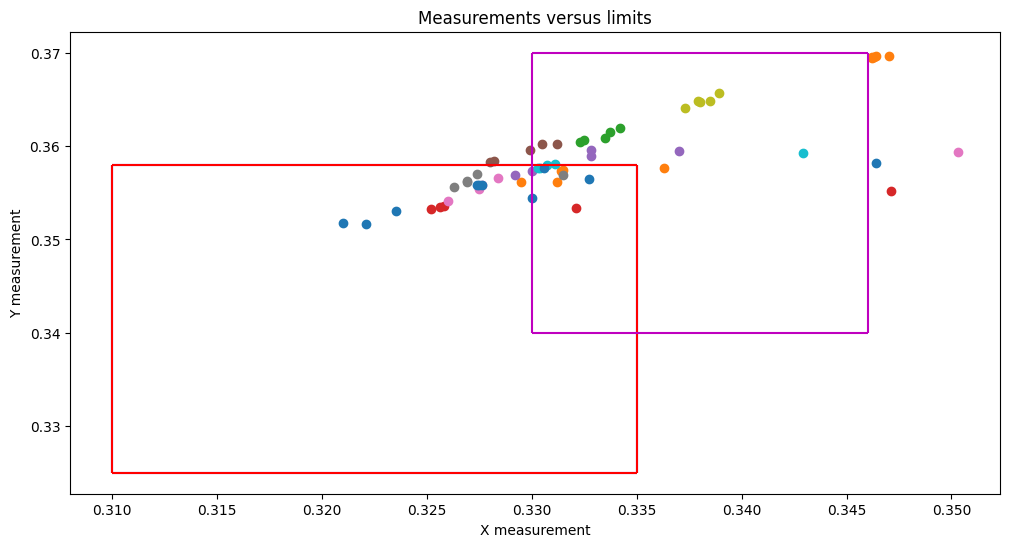

In [6]:
##Data visualization
label = fiber_selection.value
if auto_position.value is False:
    range_mapping = [0.05 - 0.0049 * (range_slider_x.value)]
    xrange = [mean_slider_x.value - range_mapping[0], mean_slider_x.value + range_mapping[0]]
    yrange = [mean_slider_y.value - range_mapping[0], mean_slider_y.value + range_mapping[0]]
else:
    range_mapping = None; xrange = None; yrange = None
display(HBox([fiber_selection, auto_position, mean_slider_x, mean_slider_y]))
display(HBox([range_slider_x, range_slider_y]))
_ = plot_simple_limits(DATA_format, glob.nests_number, xrange=xrange, yrange=yrange, limit_filter=None, fiber_filter=label)

In [ ]:
##Data export
name_pdf = glob.tooling + "_axis_visualization_" + get_date() + ".pdf"
confirmation = input("Do you want to export the data? (y/n): ").strip().lower()
if confirmation == 'y':
    output_filepath = os.path.join(os.path.abspath("../a2_output/reports"), name_pdf)
    _ = plot_to_pdf(DATA_format, name_pdf, plot="Axis")
    #os.startfile('../a2_output/Target_with_limits.xlsx')
    print(f'Analysis data and visualizations exported inside:\n{os.path.split(output_filepath)[0]}')
else:
    print("Operation canceled.")

Analysis data and visualizations exported inside:
c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\a2_output\reports
